In [17]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [18]:
def random_point():
    return([random.uniform(0,1),random.uniform(0, 1)])

In [19]:
def T_point(xmin, xmax, ymin, ymax):
    while True:
        candidate_point = random_point()
        x = candidate_point[0]
        y = candidate_point[1]
        if (x > xmin and x<xmax and y<ymax) or (y > ymin and y<ymax and x>xmin):
            return(candidate_point)
            

In [20]:
MAXN=300
xmin = 0
xmax = 0.1
ymin = 0.8
ymax = 0.9

epsilon = 0.2

X = []

for i in range(MAXN):
    point = T_point(xmin,xmax, ymin, ymax)
    X.append(point)
    
for i in range(MAXN):
    point = T_point(xmin + epsilon, xmax + epsilon, ymin - epsilon, ymax - epsilon)
    X.append(point)
X = np.asarray(X)

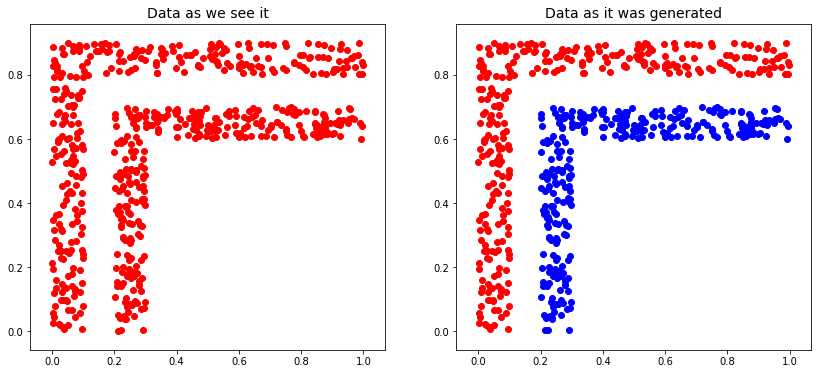

In [21]:
#Just for visualization purposes
y = np.concatenate([np.ones((MAXN,1)),2*np.ones((MAXN,1))])
#y = np.concatenate([np.ones((MAXN,1))])

plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],color='r')
plt.title('Data as we see it', size=14)

plt.subplot(1,2,2)
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],color='r')
plt.scatter(X[(y==2).ravel(),0],X[(y==2).ravel(),1],color='b')
plt.scatter(X[(y==3).ravel(),0],X[(y==3).ravel(),1],color='g')
plt.title('Data as it was generated',size=14)
fig=plt.gcf()
fig.set_size_inches((14,6))

[[0.70857927 0.89287769]
 [0.82267109 0.89967607]]


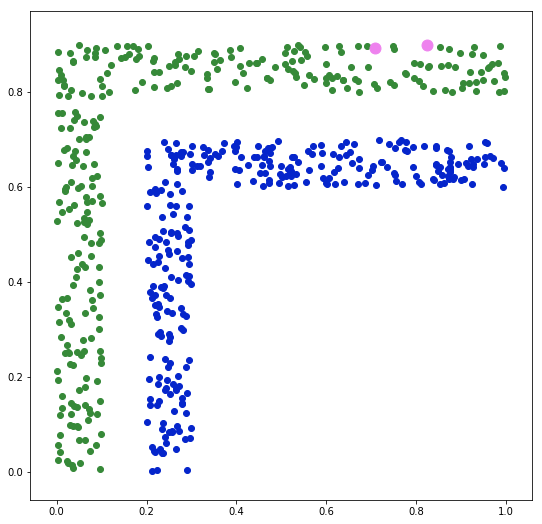

In [22]:
K =2
C=X[0:K,:].copy()
Sigma=100.*np.ones((K,X.shape[1]))
print (C)
for label in np.unique(y):
    plt.scatter(X[(y==label).ravel(),0],X[(y==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])

Pi=(1./K)*np.ones((K,1))
Sigma=100.*np.ones((K,X.shape[1]))

plt.scatter(C[:,0],C[:,1],s=120, 
           facecolors='violet', 
           linewidths=1,
           zorder=10)
fig = plt.gcf()
fig.set_size_inches((9,9))

In [23]:
from scipy.stats import multivariate_normal

def define_responsibilities(X,C,Sigma,Pi):
    r = np.zeros((X.shape[0],C.shape[0]))
    for i in range(C.shape[0]):
        d = cdist(C[i,:][np.newaxis,:],X,metric='seuclidean',V=Sigma[i,:])**2
        r[:,i]=Pi[i]*np.exp(-0.5*d)/np.prod(np.sqrt(2*np.pi)*Sigma[i,:])
    r = r/np.tile(np.sum(r,axis=1)[:,np.newaxis],(1,C.shape[0]))
    return r

def soft_kmeans2_iter(X,C,Sigma,Pi):
    I=X.shape[1]
    r = define_responsibilities(X,C,Sigma,Pi)
    for k in range(C.shape[0]):
        C[k,:]=np.sum((np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*X),axis=0)/np.sum(r[:,k])
        Sigma[k,:]= np.sum(np.tile(r[:,k][:,np.newaxis],(1,C.shape[1]))*(X-np.tile(C[k,:][np.newaxis,:],(X.shape[0],1)))**2,axis=0)/(I*np.sum(r[:,k]))
        Pi[k]=np.sum(r[:,k])/np.sum(r) 
    return C,Sigma,Pi

def evaluate_objective(X,C,Sigma,Pi):
    J=0
    for k in range(C.shape[1]):
        J += Pi[k]*multivariate_normal.pdf(X, mean=C[k,:], cov=Sigma[k,:])
    return np.sum(np.log(J))
    
def foo(C, Sigma, Pi):
    conv=[]
    for iter in range(30):
        conv.append(evaluate_objective(X,C,Sigma,Pi))
        C,Sigma,Pi = soft_kmeans2_iter(X,C,Sigma,Pi)
    print (Sigma,Pi)

    plt.figure()
    plt.plot(conv)
    plt.figure()
    r = define_responsibilities(X,C,Sigma,Pi)
    y_pred = np.argmax(r,axis=1)
    for label in np.unique(y_pred):
        plt.scatter(X[(y_pred==label).ravel(),0],X[(y_pred==label).ravel(),1],color=[np.random.rand(),np.random.rand(),np.random.rand()])


    plt.scatter(C[:,0],C[:,1],s=120, 
               #facecolors='none', 
               linewidths=2,
               zorder=10)

    from matplotlib.patches import Ellipse
    ax = plt.gca()
    ellipse = Ellipse(xy=C[0,:], width=4*np.sqrt(Sigma[0,0]), height=4*np.sqrt(Sigma[0,1]), 
                            edgecolor='r', fc='None', lw=2)
    ax.add_patch(ellipse)

    ellipse = Ellipse(xy=C[1,:], width=4*np.sqrt(Sigma[1,0]), height=4*np.sqrt(Sigma[1,1]), 
                            edgecolor='r', fc='None', lw=2)
    ax.add_patch(ellipse)


    fig = plt.gcf()
    fig.set_size_inches((9,9))

[[0.00537619 0.03537703]
 [0.02085289 0.00531095]] [[0.55517172]
 [0.44482828]]


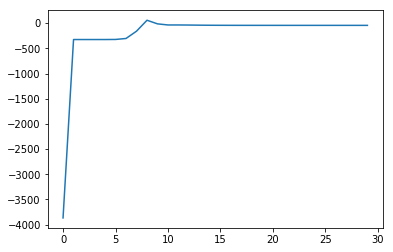

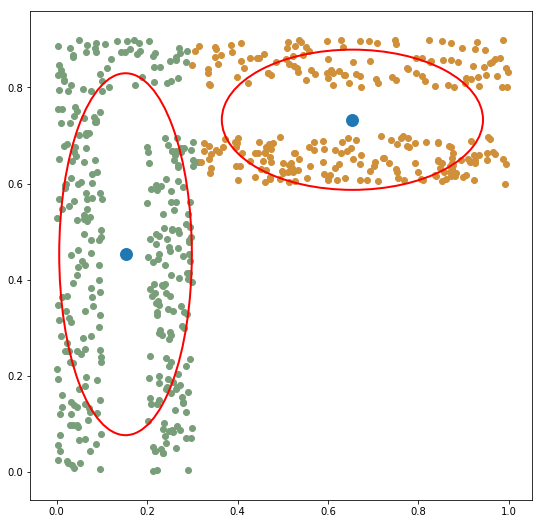

In [24]:
foo(C, Sigma, Pi)